In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image

Defining the data directories and csv file names

In [2]:
path = 'data/MURA-v1.1'
train_image_paths_csv = "train_image_paths.csv"
valid_image_paths_csv = "valid_image_paths.csv"

Reading the CSV file for training images and extracting the image paths

In [3]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

valid_images_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_images_paths.columns = ['image_path']

Extracting the labels

In [4]:
train_images_paths['label'] = train_images_paths['image_path'].map(
    lambda x: 1 if 'positive' in x else 0)

valid_images_paths['label'] = valid_images_paths['image_path'].map(
    lambda x: 1 if 'positive' in x else 0)

Extracting other relevant information and displaying the dataframe

In [5]:
train_images_paths['category']  = train_images_paths['image_path'].apply(
    lambda x: x.split('/')[2])  
train_images_paths['patientId']  = train_images_paths['image_path'].apply(
    lambda x: x.split('/')[3].replace('patient',''))

valid_images_paths['category']  = valid_images_paths['image_path'].apply(
    lambda x: x.split('/')[2])  
valid_images_paths['patientId']  = valid_images_paths['image_path'].apply(
    lambda x: x.split('/')[3].replace('patient',''))

train_images_paths.head()

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,XR_SHOULDER,00002


Printing train dataset information

In [6]:
total_number_of_training_images = np.shape(train_images_paths)[0]
print("total number of images:",total_number_of_training_images )
print ("\nnumber of null values\n", train_images_paths.isnull().sum())


categories_counts = pd.DataFrame(train_images_paths['category'].value_counts())
print ('\n\ncategories:\n',categories_counts )
print('\n\nnumber of patients:',train_images_paths['patientId'].nunique())
print('\nnumber of labels:',train_images_paths['label'].nunique())
print ('\npositive casses:',len(train_images_paths[train_images_paths['label']==1]))
print ('\nnegative casses:',len(train_images_paths[train_images_paths['label']==0]))

total number of images: 36808

number of null values
 image_path    0
label         0
category      0
patientId     0
dtype: int64


categories:
              count
category          
XR_WRIST      9752
XR_SHOULDER   8379
XR_HAND       5543
XR_FINGER     5106
XR_ELBOW      4931
XR_FOREARM    1825
XR_HUMERUS    1272


number of patients: 11184

number of labels: 2

positive casses: 14873

negative casses: 21935


In [7]:
counts = (
    train_images_paths
    .groupby(['category', 'patientId'])
    .size()
    .reset_index(name='n_images')
)

dist = (
    counts
    .groupby(['category', 'n_images'])
    .size()
    .reset_index(name='n_patients')
    .sort_values(['category', 'n_images'])
)

pivot = dist.pivot(
    index='n_images', columns='category', values='n_patients').fillna(0).astype(int)

print(pivot)

category  XR_ELBOW  XR_FINGER  XR_FOREARM  XR_HAND  XR_HUMERUS  XR_SHOULDER  \
n_images                                                                      
1               31        336          84       28          22          289   
2              691        155         651      484         478          487   
3              608       1172          91     1306          61          920   
4              272        132          32       65          20          834   
5               68         27           5       19           5           82   
6               27         30           1       36           1           33   
7               11          6           1        3           0           21   
8                1          5           0        2           0           17   
9                1          1           0        0           0            1   
10               1          1           0        1           0            2   
11               0          0           0        1  

Create dataloaders for training

In [9]:
from helpers.augments import make_transform
from helpers.patientdataset import load_df, PatientDataset, patient_collate_fn, make_loader

DATA_DIR       = "data/MURA-v1.1"
PARENT_DIR     = "data"

train_loader = make_loader(load_df("train_image_paths.csv", DATA_DIR), augment=True,
                           parent_dir=PARENT_DIR,
                           batch_size=16, shuffle=True, num_workers=2, pin_memory=True,
                           drop_last=True)

val_loader   = make_loader(load_df("valid_image_paths.csv", DATA_DIR), augment=False,
                           parent_dir=PARENT_DIR,
                           batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

Create datasets and dataloaders

Sanity check

In [11]:
x,y = next(iter(train_loader))
print('lengths of x, y:\n', len(x), len(y))
print('shapes of x, y:\n', x[0].shape, y[0].shape)

lengths of x, y:
 16 16
shapes of x, y:
 torch.Size([1, 1, 224, 224]) torch.Size([])


In [12]:
x,y = next(iter(val_loader))
print('lengths of x, y:\n', len(x), len(y))
print('shapes of x, y:\n', x[0].shape, y[0].shape)

lengths of x, y:
 16 16
shapes of x, y:
 torch.Size([4, 1, 224, 224]) torch.Size([])


Visualizing xrays of a random patient

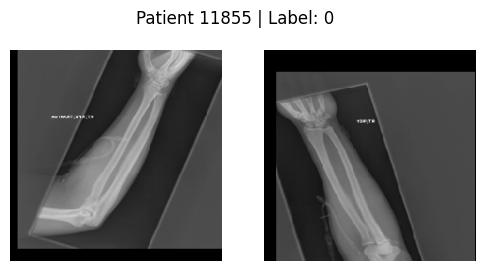

In [14]:
import random

idx = random.randint(0, len(train_ds)-1)
imgs, label = train_ds[idx]

n = imgs.shape[0]
cols = min(5, n)
rows = (n + cols - 1) // cols

plt.figure(figsize=(3*cols, 3*rows))
for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i][0], cmap='gray')
    plt.axis('off')

plt.suptitle(f"Patient {idx} | Label: {int(label.item())}", fontsize=12)
plt.show()

Custom Visual Transformer

In [15]:
# from architectures.custom_vit import Custom_ViT
#vit = Custom_ViT(img_size=256, patch_size=16, in_chans=1,
#     embed_dim=256, depth=6, heads=8)

Pretrained Resnets

In [16]:
#from architectures.resnet50 import ResNet50_Backbone
#backbone = ResNet50_Backbone(embed_dim=256, freeze_until='layer4')

#from architectures.resnet101 import ResNet101_Backbone
#backbone = ResNet101_Backbone(embed_dim=256, freeze_until='layer4')

from architectures.resnet152 import ResNet152_Backbone
backbone = ResNet152_Backbone(embed_dim=256, freeze_until='layer4')

unfreeze_groups = [
    backbone.backbone[7],
    backbone.backbone[6],
    backbone.backbone[5],
    backbone.backbone[4],
]

Pretrained ViTs

In [16]:
#from architectures.vit_l_16 import ViT_L_16_Backbone
#backbone = ViT_L_16_Backbone(embed_dim=256, freeze_until='encoder_layer_22')

#from architectures.vit_b_32 import ViT_B_32_Backbone
#backbone = ViT_B_32_Backbone(embed_dim=256, freeze_until='encoder_layer_11')

backbone_kwargs = dict(embed_dim=256, freeze_until='encoder_layer_19', dropout=0.1)

from architectures.vit_l_32 import ViT_L_32_Backbone
backbone = ViT_L_32_Backbone(**backbone_kwargs) # max is 22

unfreeze_groups = [
    backbone.backbone.encoder.layers[-1],
    backbone.backbone.encoder.layers[-2],
    backbone.backbone.encoder.layers[-3],
    backbone.backbone.encoder.layers[-4],
    backbone.backbone.encoder.layers[-5],
    backbone.backbone.encoder.layers[-6],
    backbone.backbone.encoder.layers[-7],
    backbone.backbone.encoder.layers[-8],
    backbone.backbone.encoder.layers[-9],
    backbone.backbone.encoder.ln, 
    backbone.backbone.class_token
    # backbone.backbone.encoder.pos_embedding
]

Parent Model

In [18]:
from architectures.classifier import Classifier
classifier_kwargs = dict(embed_dim=256, mlp_depth=2)

model = Classifier(backbone, **classifier_kwargs)

To load from a checkpoint

In [25]:
from helpers.checkpoint import load_checkpoint
from architectures.vit_l_32 import ViT_L_32_Backbone  # import triggers @register

model, config = load_checkpoint("models/best_model_vit_l_32.pt", device="cuda")
print(config)

{'backbone_cls': 'ViT_L_32_Backbone', 'backbone_kwargs': {'embed_dim': 256, 'freeze_until': 'encoder_layer_19', 'dropout': 0.1}, 'classifier_kwargs': {'embed_dim': 256, 'mlp_depth': 2}, 'pos_weight': 1.47, 'lr': 0.0001}


Model + dataset info

In [19]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Initially trainable parameters: {trainable_params:,}")

print(f"Train patients/studies: {len(train_ds)}")
print(f"Val patients/studies: {len(valid_ds)}")

print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")

Total parameters: 314,135,786
Initially trainable parameters: 37,018,858
Train patients/studies: 13457
Val patients/studies: 1199
Train batches: 841
Val batches:   75


Set up checkpointing

In [20]:
from helpers.checkpoint import save_checkpoint

def save_fn(model):
    save_checkpoint(
        model,
        "models/best_model_vit_l_32.pt",
        backbone_cls=type(backbone).__name__,   # "ViT_L_32_Backbone"
        backbone_kwargs=backbone_kwargs,
        classifier_kwargs=classifier_kwargs,
        # other stuff to record
        pos_weight=1.47,
        lr=1e-4
    )

In [ ]:
from helpers.trainer import fit

# class imbalance: ~21935 neg / ~14873 pos ≈ 1.47
model = fit(
    model, train_loader, val_loader,
    n_epochs=50,
    lr=1e-4,
    pos_weight=1.47,
    unfreeze_groups=unfreeze_groups,
    scheduler_patience=3,
    unfreeze_patience=3,
    unfreeze_lr_scale=0.5,
    checkpoint_path="models/best_model_vit_l_32.pt",
    save_fn=save_fn
)

[Unfreezer] 9 group(s) queued for progressive unfreezing.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001 Train:   0%|          | 0/841 [00:00<?, ?it/s]

Evaluate the model

In [27]:
from helpers.trainer import evaluate

device = 'cuda'
model.to(device)
val_loss, val_acc, kappa = evaluate(model, val_loader, device, pos_weight=1.47)

print(
    f"val loss {val_loss:.4f}  acc {val_acc:.4f}  | ",
    f"kappa {kappa:.4f}"
)

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

val loss 0.7335  acc 0.7773  |  kappa 0.5430
